In [37]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [38]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"sumitkr6125","key":"a23de5720e3a51c51677e1c28589193a"}'}

In [39]:
import os
import zipfile

# Create a hidden Kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move the uploaded kaggle.json to the correct location
!mv kaggle.json /root/.kaggle/kaggle.json

# Set permission to secure the file
!chmod 600 /root/.kaggle/kaggle.json



mv: cannot stat 'kaggle.json': No such file or directory


In [40]:
# Download the Chest X-ray Pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [41]:
# Unzip the downloaded dataset
with zipfile.ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("chest_xray")


In [42]:
import os, shutil
import random
import numpy as np
import pandas as pd
import skimage
import cv2
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [43]:
!pip install opencv-python

In [44]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    # Filter out invalid entries
    valid_data = [item for item in data if len(item) == 2 and item[0].shape == (img_size, img_size)]

    # Split into features and labels
    X = np.array([item[0] for item in valid_data])
    y = np.array([item[1] for item in valid_data])

    return X, y


In [45]:
train_X, train_y = get_data("chest_xray/chest_xray/train")
test_X, test_y = get_data("chest_xray/chest_xray/test")
val_X, val_y = get_data("chest_xray/chest_xray/val")


# **Showing Chest X-Rays**

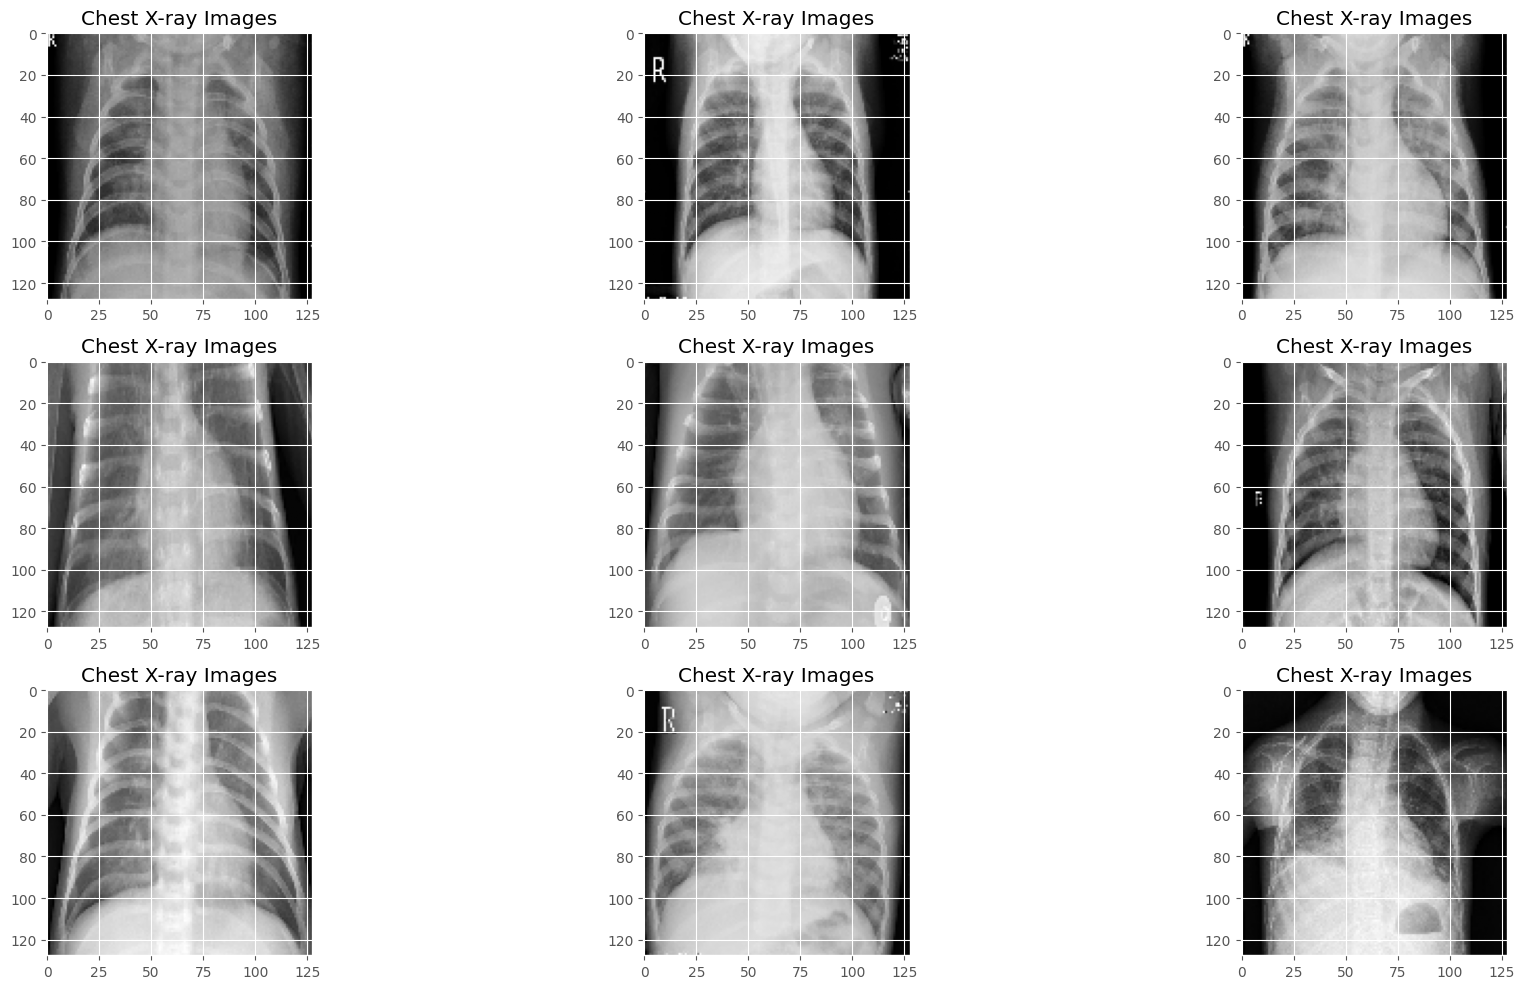

In [46]:

plt .figure(figsize=(20, 10))

for i in range(9):
    plt .subplot(3, 3, i+1)
    plt .imshow(train_X[i], cmap='gray')
    plt .title(f"Label: {train_y[i]}")
    plt .axis('on')
    plt.title("Chest X-ray Images")
plt .tight_layout()

# Directories of pneumonia and normal **images**


In [47]:
pneumonia = os.listdir("chest_xray/chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/chest_xray/train/PNEUMONIA"
normal = os.listdir("chest_xray/chest_xray/train/NORMAL")
normal_dir = "chest_xray/chest_xray/train/NORMAL"


# **Showing PNEUMONIA X-RAY IMAGES**

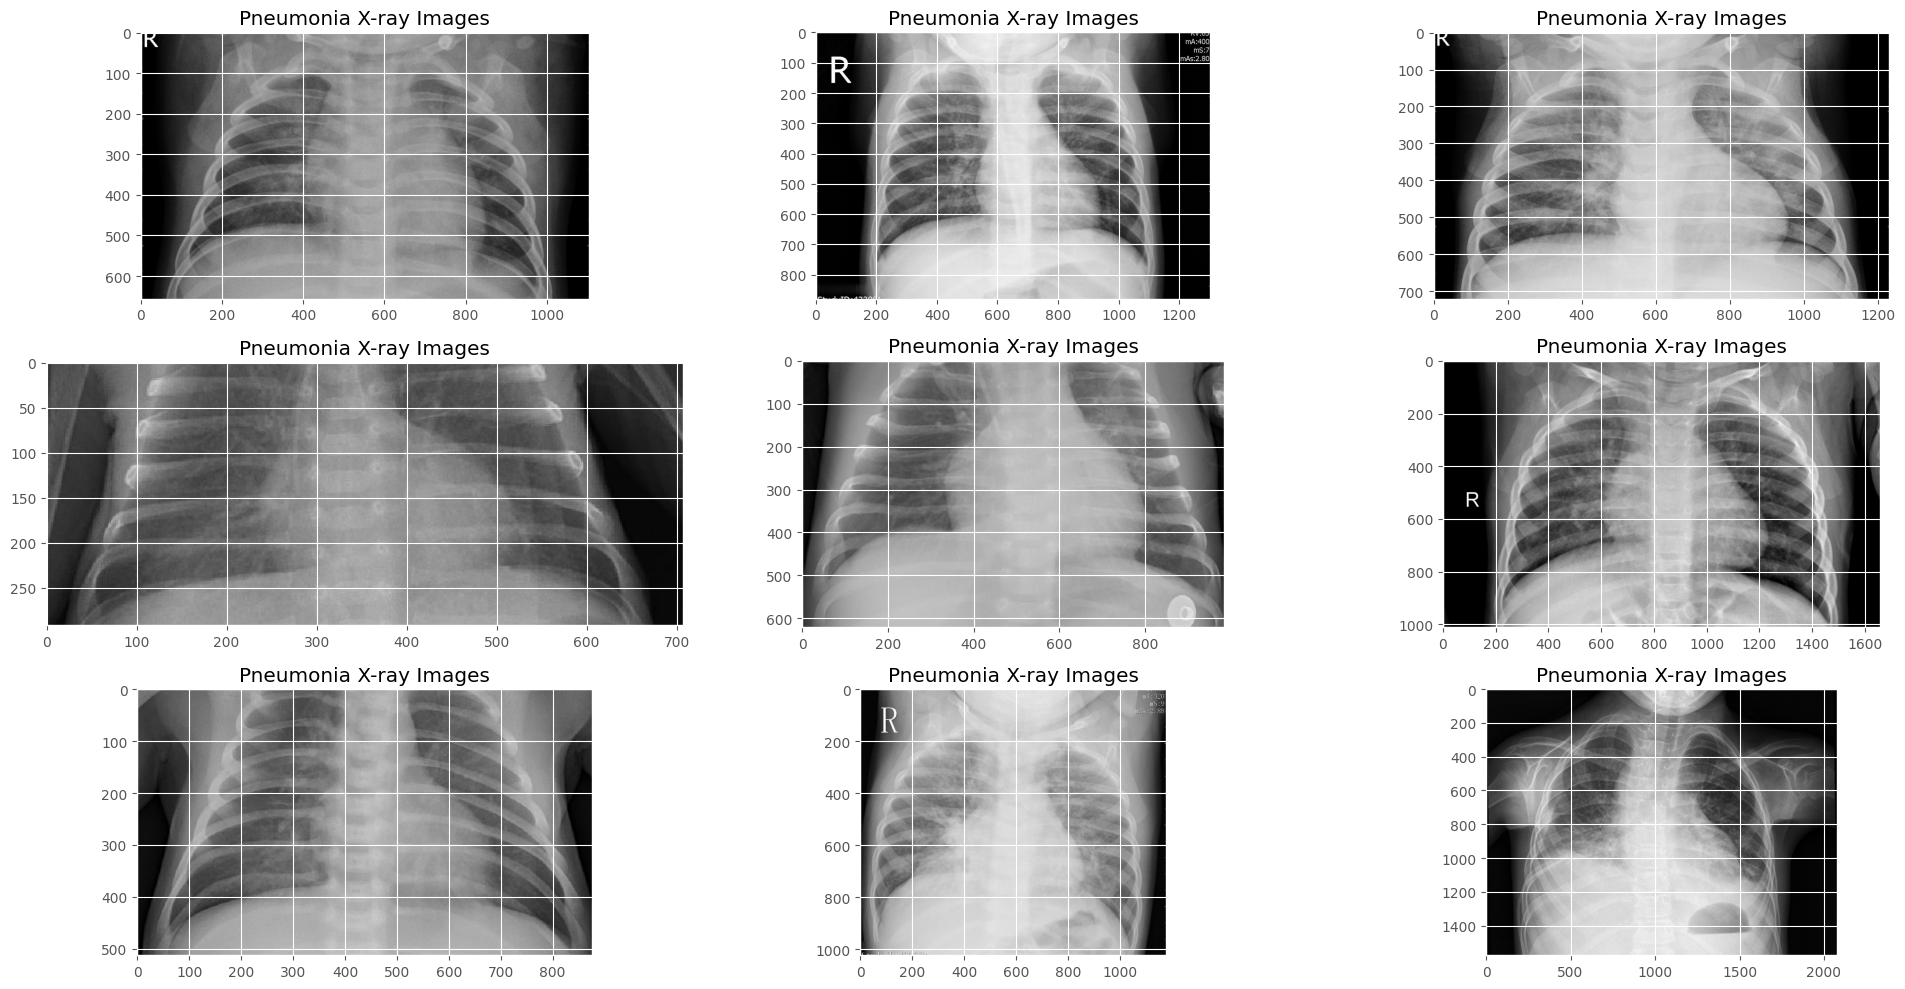

In [48]:
plt .figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('on')
    plt.title("Pneumonia X-ray Images")
plt.tight_layout()

# **Showing NORMAL CHEST X-RAY IMAGES**

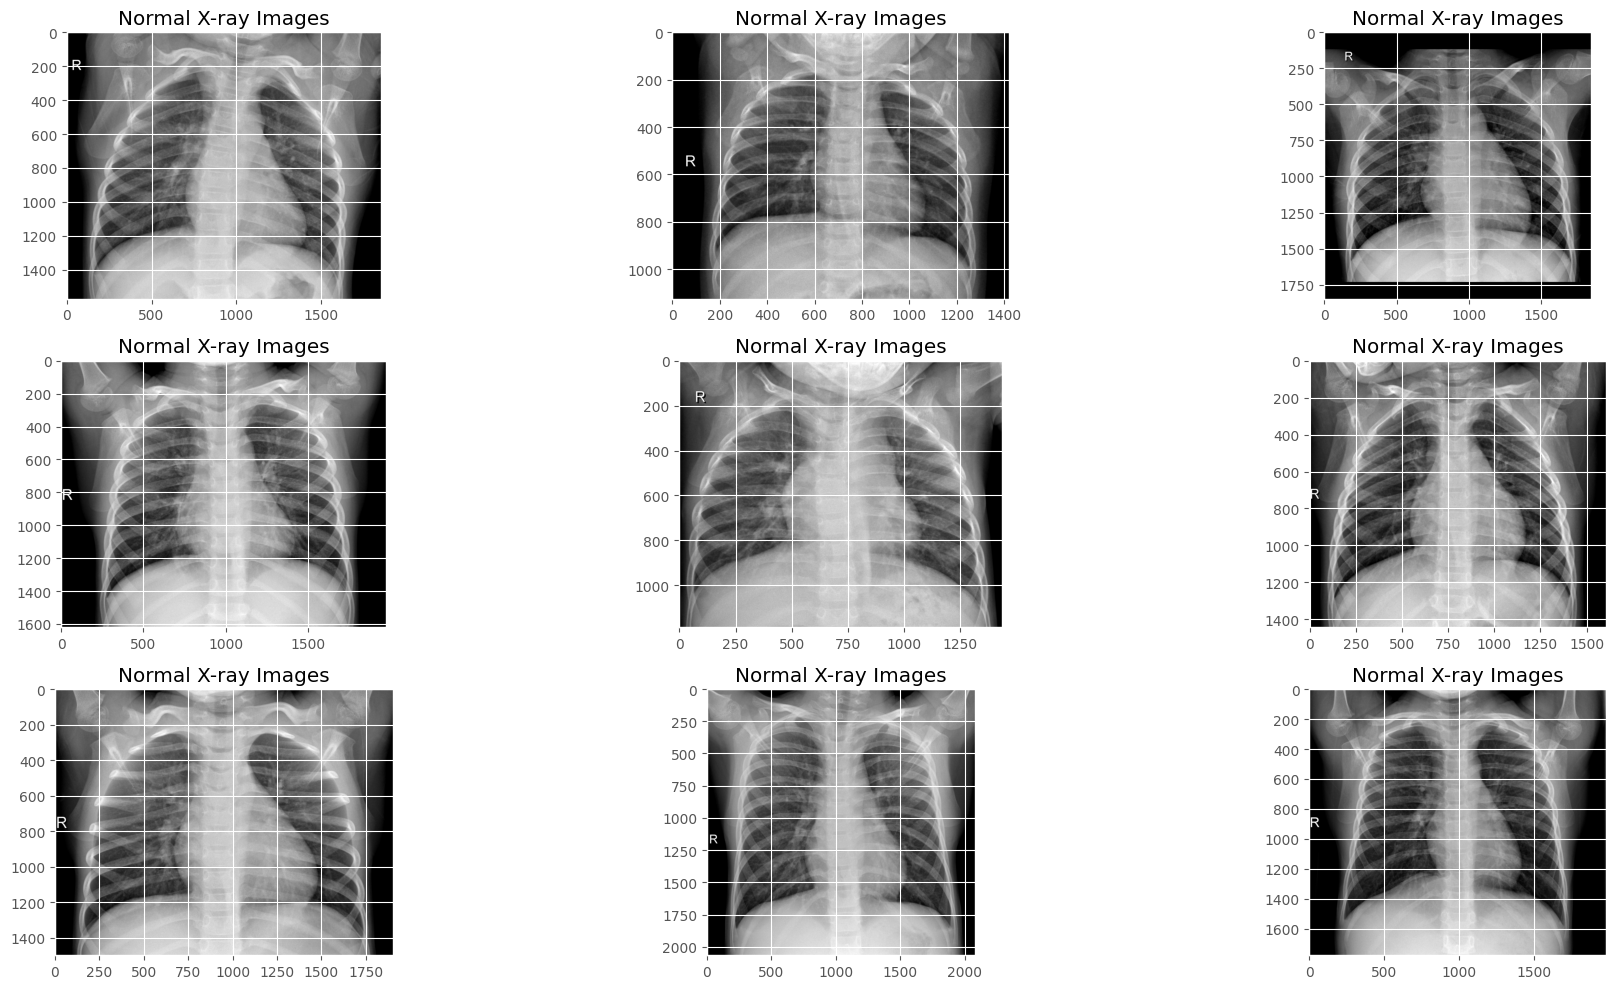

In [49]:
plt .figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('on')
    plt.title("Normal X-ray Images")
plt.tight_layout()

# **COUNT PLOT OF PNEUMONIA vs NORMAL in TRAINING DATA**

Text(0.5, 1.0, 'Count of Pneumonia vs Normal Cases in Training Data')

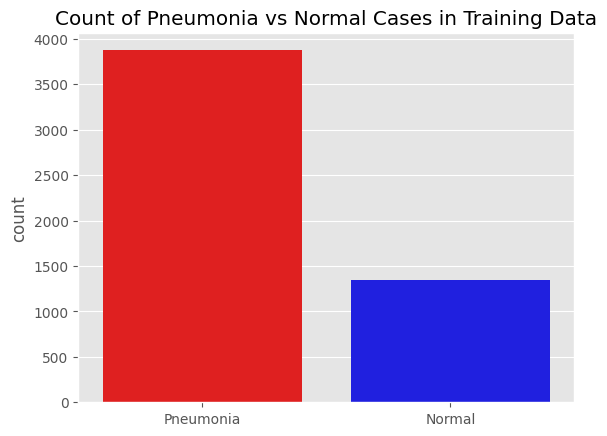

In [50]:
listx = []
for label in train_y:
  if(label == 0):
    listx.append("Pneumonia")
  else:
    listx.append("Normal")
sns.countplot(x=listx, hue=listx, palette={"Pneumonia": "red", "Normal": "blue"}, legend=False)
plt.title("Count of Pneumonia vs Normal Cases in Training Data")

## **DATA AUGMENTATION AND RESIZING**

In [51]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau




In [52]:
train_datagen =  ImageDataGenerator(rescale = 1./255,
                   horizontal_flip = 0.4,
                   vertical_flip = 0.4,
                   rotation_range = 0.4,
                   zoom_range = 0.4,
                   shear_range = 0.2,
                   fill_mode = 'nearest'
                   )

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [53]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                  batch_size = 32,
                                  class_mode = 'categorical',
                                  target_size = (128, 128),
                                  seed = 42,
                                  shuffle = True,
                                  color_mode = 'rgb'
                                  )
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                  batch_size = 32,
                                  class_mode = 'categorical',
                                  target_size = (128, 128),
                                  seed = 42,
                                  shuffle = True,
                                  color_mode = 'rgb'
                                  )

test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                  batch_size = 32,
                                  class_mode = 'categorical',
                                  target_size = (128, 128),
                                  seed = 42,
                                  shuffle = True,
                                  color_mode = 'rgb'
                                  )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [54]:
class_labels = train_generator.class_indices
print(class_labels)

{'NORMAL': 0, 'PNEUMONIA': 1}


# **RESNET50 CNN Architecture**

In [55]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model with pre-trained ImageNet weights, excluding the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Display the model summary
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [56]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x) # 2 classes: Normal and Pneumonia

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 31,977,090 (121.98 MB)

 Trainable params: 31,923,970 (121.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

# **Adam Optimizer**

In [57]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# **Model training**

In [59]:
# Train the model
history = model.fit(train_generator,
                    epochs=12, # You can adjust the number of epochs
                    validation_data=valid_generator,
                    callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8524 - loss: 0.4910 

163/163 ━━━━━━━━━━━━━━━━━━━━ 1776s 11s/step - accuracy: 0.8527 - loss: 0.4899 - val_accuracy: 0.5000 - val_loss: 17.2043 - learning_rate: 1.0000e-04
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9421 - loss: 0.1470 

163/163 ━━━━━━━━━━━━━━━━━━━━ 1770s 11s/step - accuracy: 0.9421 - loss: 0.1470 - val_accuracy: 0.5000 - val_loss: 6.8523 - learning_rate: 1.0000e-04
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9504 - loss: 0.1207 

163/163 ━━━━━━━━━━━━━━━━━━━━ 1809s 11s/step - accuracy: 0.9504 - loss: 0.1208 - val_accuracy: 0.5000 - val_loss: 3.0881 - learning_rate: 1.0000e-04
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 1750s 10s/step - accuracy: 0.9587 - loss: 0.1095 - val_accuracy: 0.5000 - val_loss: 6.6910 - learning_rate: 1.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 1686s 10s/step - accuracy: 0.9615 - loss: 0.1119 - val_accuracy: 0.5000 - val_loss: 12.1347 - learning_rate: 1.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 1707s 10s/step - accuracy: 0.9669 - loss: 0.0899 - val_accuracy: 0.5000 - val_loss: 13.1451 - learning_rate: 1.0000e-04
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 1697s 10s/step - accuracy: 0.9723 - loss: 0.0698 - val_accuracy: 0.5000 - val_loss: 7.5239 - learning_rate: 5.0000e-05
Epoch 8/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 1709s 10s/step - accuracy: 0.9753 - loss: 0.0646 - val_accuracy: 0.5000 - val_loss: 3.2085 - learning_rate: 5.0000e-05


# **Showing Model Accuracy and Loss**

In [60]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6308 - loss: 2.5173
Test Loss: 2.5580058097839355
Test Accuracy: 0.625


# **Graphs Demonstration**

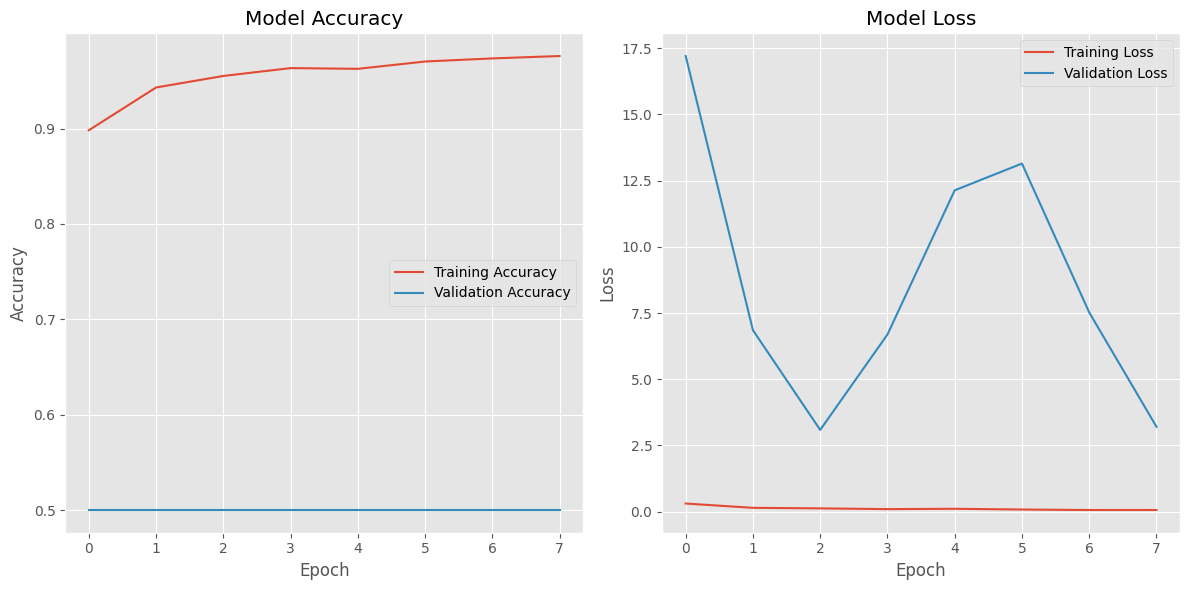

In [61]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
import json

# Create a dictionary to hold the performance metrics and history
performance_data = {
    "test_loss": loss,
    "test_accuracy": accuracy,
    "training_history": history.history
}

# Save the data to a JSON file
with open("model_performance.json", "w") as f:
    json.dump(performance_data, f)

print("Model performance and history saved to model_performance.json")

Model performance and history saved to model_performance.json


# Task
Generate Grad-CAM heatmaps for several images from the "NORMAL" and "PNEUMONIA" classes using the trained model and display them.

## Load the model

### Subtask:
Load the best performing model saved during training.


**Reasoning**:
Load the best performing model saved during training using `load_model`.



In [65]:
loaded_model = load_model('best_model.h5')

## Prepare an image

### Subtask:
Select and preprocess an image for Grad-CAM analysis.


**Reasoning**:
Select an image file path, read the image, resize it, convert it to RGB, normalize the pixel values, and expand dimensions for Grad-CAM analysis.



In [66]:
import os
import cv2
import numpy as np

# Choose an image file path (example: a pneumonia image from the test set)
image_filename = os.listdir("chest_xray/chest_xray/test/PNEUMONIA")[0]
image_path = os.path.join("chest_xray/chest_xray/test/PNEUMONIA", image_filename)

# Read the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image
img = cv2.resize(img, (img_size, img_size))

# Convert grayscale to RGB (3 channels)
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Normalize pixel values
img_rgb = img_rgb / 255.0

# Expand dimensions to match model input shape (batch_size, height, width, channels)
img_input = np.expand_dims(img_rgb, axis=0)

print(f"Selected image path: {image_path}")
print(f"Image shape after preprocessing: {img_input.shape}")

Selected image path: chest_xray/chest_xray/test/PNEUMONIA/person1610_virus_2793.jpeg
Image shape after preprocessing: (1, 128, 128, 3)


## Generate grad-cam heatmap

### Subtask:
Create a function to generate the heatmap using the loaded model and the chosen image. This will involve identifying the last convolutional layer and computing the gradients.


**Reasoning**:
Define the function to generate the Grad-CAM heatmap as described in the instructions.



In [68]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the final class predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Compute the activations of the last convolutional layer and the predictions
        last_conv_layer_output, predictions = grad_model(img_array)

        # Find the predicted class (the one with the highest probability)
        pred_index = tf.argmax(predictions[0])
        # Get the loss for the predicted class
        class_channel = predictions[:, pred_index]

    # Compute the gradients of the predicted class with respect to the output of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Get the mean intensity of the gradient over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the mean intensity of the gradient
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU activation to the heatmap
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        # Handle the case where max_val is 0 to avoid division by zero
        heatmap = heatmap * 0
    else:
        heatmap = heatmap / max_val

    return heatmap.numpy()

**Reasoning**:
Identify the name of the last convolutional layer in the loaded model to be used in the Grad-CAM function.



In [69]:
# Find the last convolutional layer in the model
last_conv_layer_name = None
for layer in reversed(loaded_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"Name of the last convolutional layer: {last_conv_layer_name}")

Name of the last convolutional layer: conv5_block3_3_conv


**Reasoning**:
Generate the heatmap for the preprocessed image using the defined function and the identified last convolutional layer.



In [70]:
# Generate the heatmap
heatmap = make_gradcam_heatmap(img_input, loaded_model, last_conv_layer_name)

# Print the shape of the generated heatmap
print(f"Shape of the generated heatmap: {heatmap.shape}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


Shape of the generated heatmap: (4, 4)


## Display heatmap

### Subtask:
Superimpose the generated heatmap onto the original image to visualize the areas of interest.


**Reasoning**:
Superimpose the generated heatmap onto the original image and display the original and superimposed images.



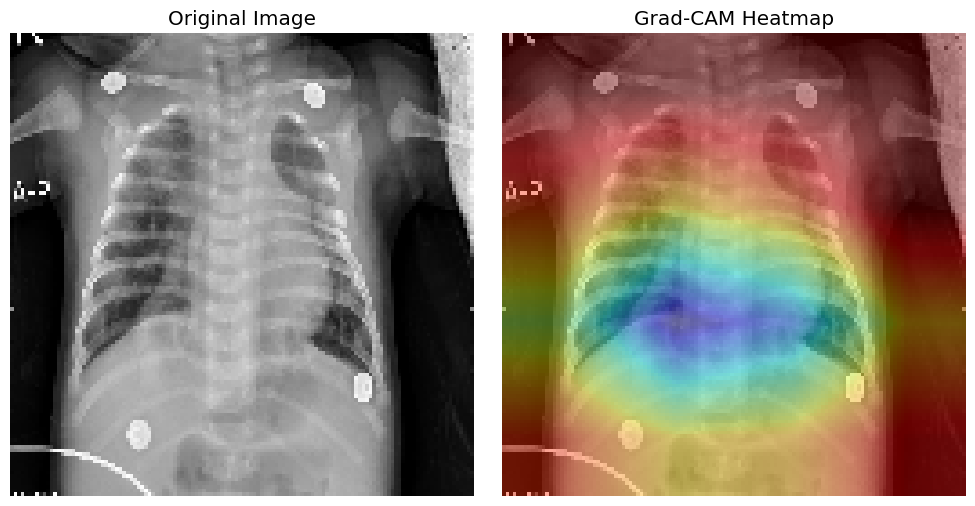

In [71]:
# Load the original image in color
original_img = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Resize the original image to match the model's input size
original_img = cv2.resize(original_img, (img_size, img_size))

# Resize the heatmap to the original image size
heatmap_resized = cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR)

# Convert heatmap to a 3-channel image
heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3] * 255

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored.astype('uint8'), 0.4, 0)

# Display the original and superimposed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()

## Repeat for multiple images

### Subtask:
Apply the Grad-CAM process to several examples from both the "NORMAL" and "PNEUMONIA" classes to compare the visualizations.


**Reasoning**:
Create lists of image paths for both classes from the test set and iterate through them to generate and display Grad-CAM heatmaps for several examples.



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


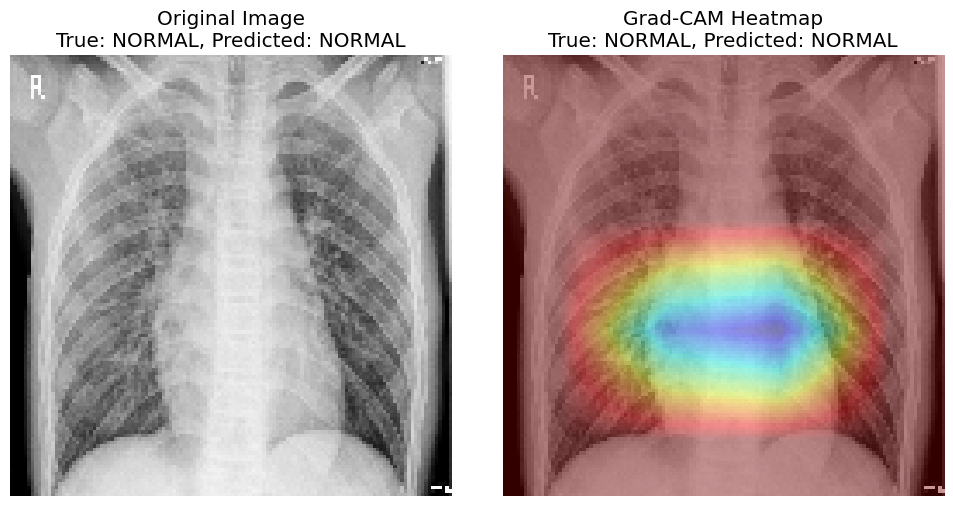

Saved grad_cam_outputs/original/original_0.png and grad_cam_outputs/heatmap/heatmap_0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


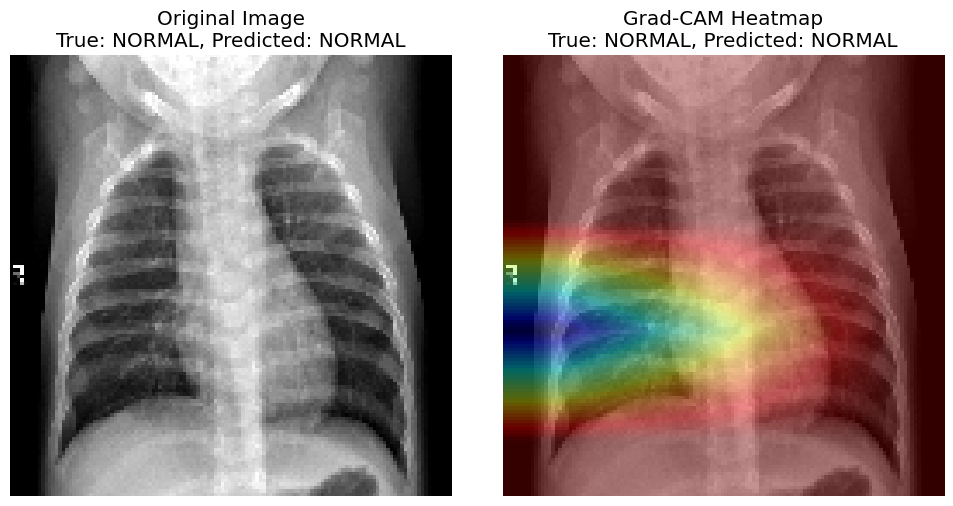

Saved grad_cam_outputs/original/original_1.png and grad_cam_outputs/heatmap/heatmap_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


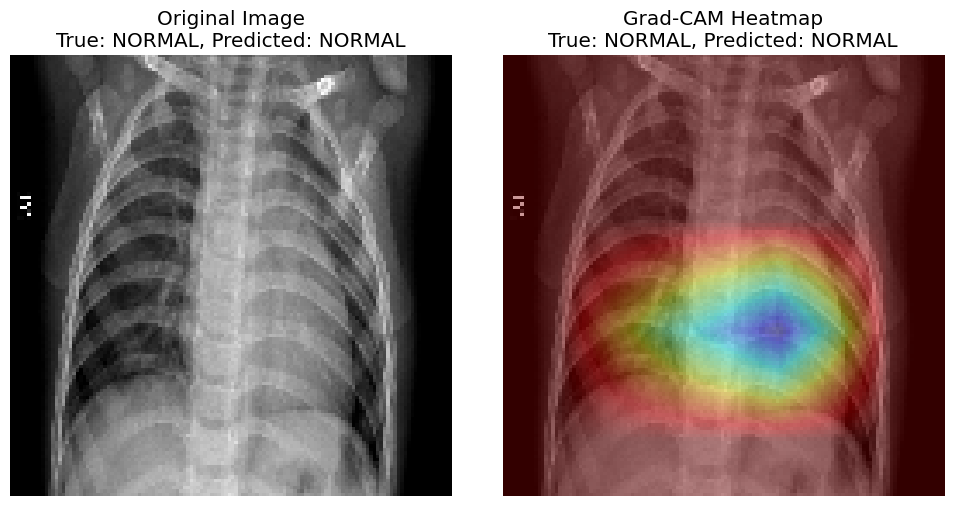

Saved grad_cam_outputs/original/original_2.png and grad_cam_outputs/heatmap/heatmap_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


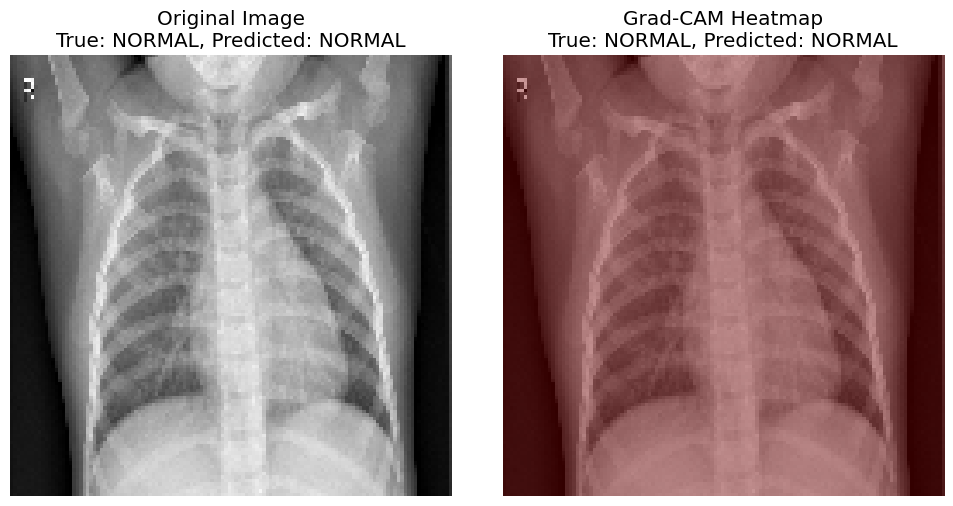

Saved grad_cam_outputs/original/original_3.png and grad_cam_outputs/heatmap/heatmap_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


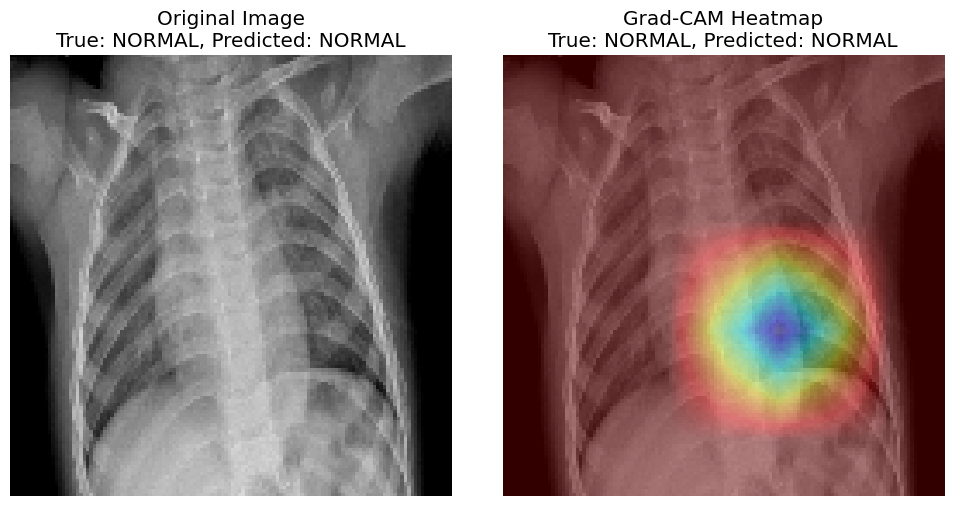

Saved grad_cam_outputs/original/original_4.png and grad_cam_outputs/heatmap/heatmap_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


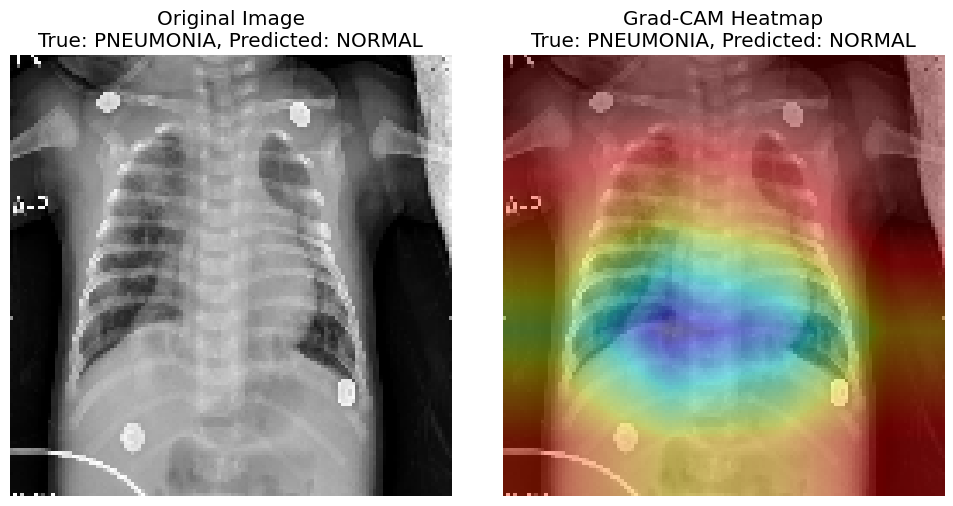

Saved grad_cam_outputs/original/original_5.png and grad_cam_outputs/heatmap/heatmap_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


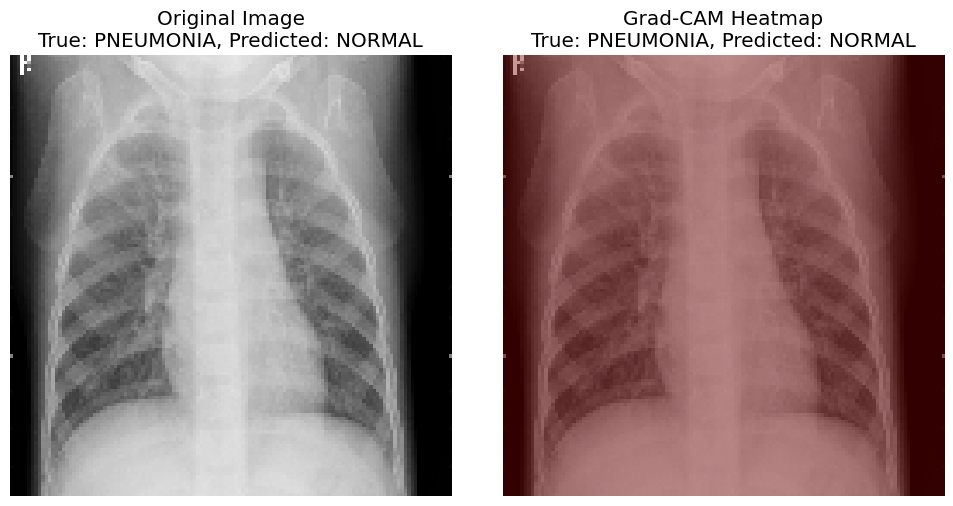

Saved grad_cam_outputs/original/original_6.png and grad_cam_outputs/heatmap/heatmap_6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


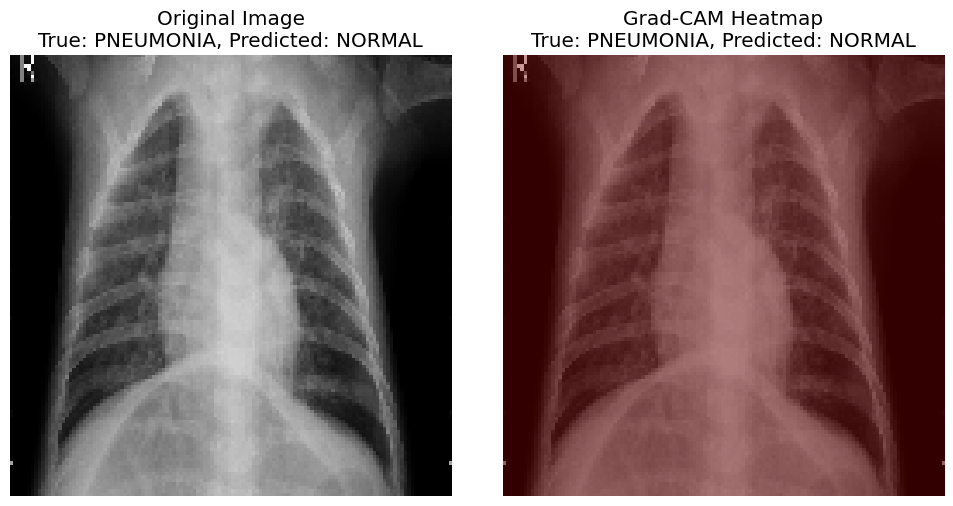

Saved grad_cam_outputs/original/original_7.png and grad_cam_outputs/heatmap/heatmap_7.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


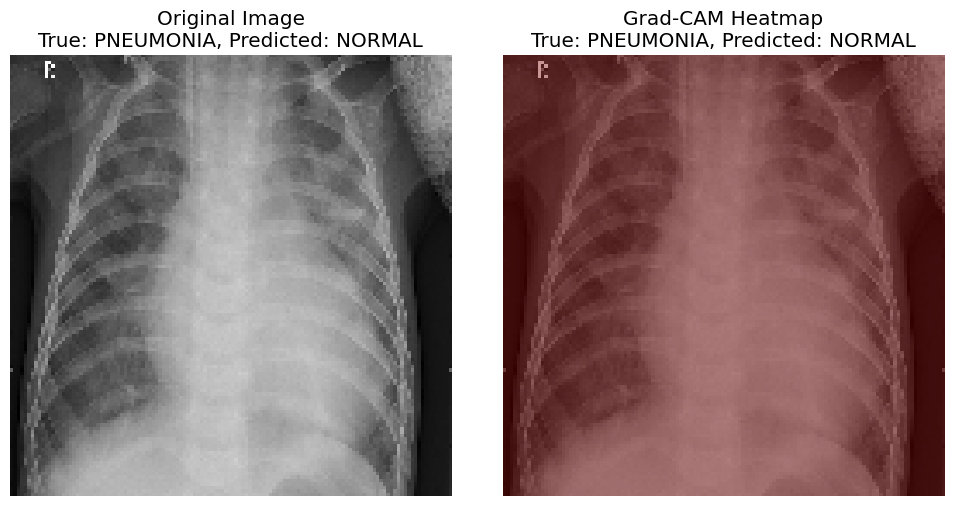

Saved grad_cam_outputs/original/original_8.png and grad_cam_outputs/heatmap/heatmap_8.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


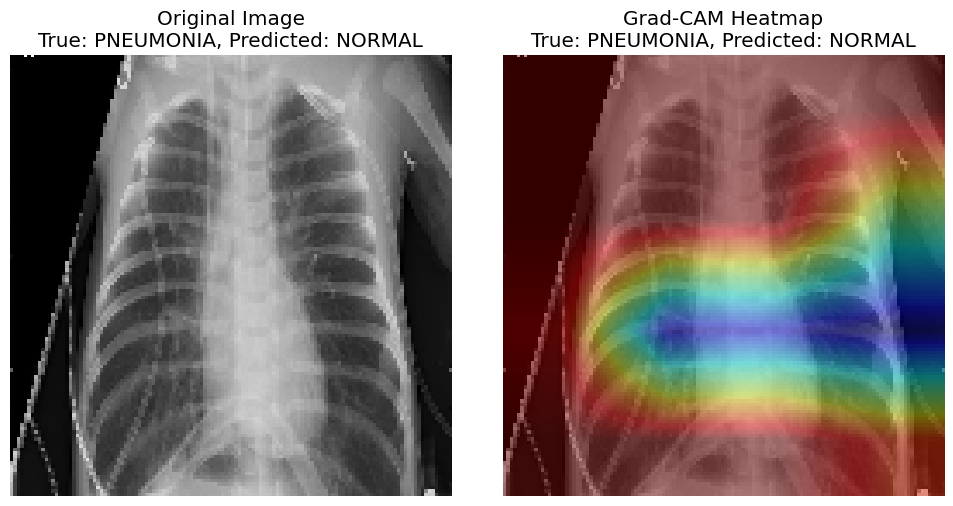

Saved grad_cam_outputs/original/original_9.png and grad_cam_outputs/heatmap/heatmap_9.png


In [73]:
# Create lists of image paths for NORMAL and PNEUMONIA cases from the test set
normal_test_images = [os.path.join("chest_xray/chest_xray/test/NORMAL", img) for img in os.listdir("chest_xray/chest_xray/test/NORMAL")[:5]] # Get first 5 normal images
pneumonia_test_images = [os.path.join("chest_xray/chest_xray/test/PNEUMONIA", img) for img in os.listdir("chest_xray/chest_xray/test/PNEUMONIA")[:5]] # Get first 5 pneumonia images

# Combine the lists for easier iteration
all_test_images = normal_test_images + pneumonia_test_images

# Create directories to save the images if they don't exist
os.makedirs("grad_cam_outputs/original", exist_ok=True)
os.makedirs("grad_cam_outputs/heatmap", exist_ok=True)

# Iterate through the list of image paths
for i, image_path in enumerate(all_test_images):
    # Determine the true class from the file path
    true_class = "NORMAL" if "NORMAL" in image_path else "PNEUMONIA"

    # a. Load and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_rgb_normalized = img_rgb / 255.0
    img_input = np.expand_dims(img_rgb_normalized, axis=0)

    # b. Generate the Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_input, loaded_model, last_conv_layer_name)

    # c. Load the original color image, resize the heatmap, and superimpose
    original_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_img = cv2.resize(original_img, (img_size, img_size))
    heatmap_resized = cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR)
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3] * 255
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored.astype('uint8'), 0.4, 0)

    # Make a prediction for the current image to get the predicted class
    predictions = loaded_model.predict(img_input)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = labels[predicted_class_index]


    # d. Display the original image and the superimposed image
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image\nTrue: {true_class}, Predicted: {predicted_class}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM Heatmap\nTrue: {true_class}, Predicted: {predicted_class}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the original and superimposed images
    original_img_filename = os.path.join("grad_cam_outputs/original", f"original_{i}.png")
    heatmap_img_filename = os.path.join("grad_cam_outputs/heatmap", f"heatmap_{i}.png")
    cv2.imwrite(original_img_filename, original_img)
    cv2.imwrite(heatmap_img_filename, superimposed_img)

    print(f"Saved {original_img_filename} and {heatmap_img_filename}")

## Summary:

### Data Analysis Key Findings

*   The best performing model was successfully loaded from the file `best_model.h5`.
*   The name of the last convolutional layer in the loaded model was identified as `conv5_block3_3_conv`.
*   A function `make_gradcam_heatmap` was successfully created and used to generate Grad-CAM heatmaps by calculating gradients of the predicted class output with respect to the last convolutional layer's activations.
*   The generated heatmaps were successfully resized and superimposed onto the corresponding original images for both "NORMAL" and "PNEUMONIA" cases.
*   The process was successfully repeated for multiple images from both classes in the test set, displaying the original image, the superimposed heatmap, and the true and predicted classes for each.

### Insights or Next Steps

*   Analyze the generated heatmaps for different classes to understand if the model is focusing on medically relevant areas for its predictions.
*   Investigate cases where the model makes incorrect predictions to see if the Grad-CAM heatmaps reveal insights into why the model might have misclassified the image.
